## Training

In [1]:
from keras.models import Sequential,Model
from keras.layers import Dropout, Flatten, Dense, Input, Add, merge, concatenate
from keras.layers.convolutional import Conv3D
from keras.layers.pooling import MaxPooling3D, GlobalAveragePooling3D, AveragePooling3D
from keras import metrics
from keras import optimizers
from keras.utils import plot_model
from keras import backend as K
from keras.utils.training_utils import multi_gpu_model
from keras.utils.data_utils import Sequence
from keras.callbacks import ModelCheckpoint
from keras.initializers import he_uniform
from keras.initializers import glorot_uniform

import numpy as np
import sys
import h5py
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append("models/")
sys.path.append("scripts/")

/usr/local/anaconda3/envs/deeplearning/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0, 1, 2, 3"

In [3]:
from my_classes import DataGenerator, AugmentedDataGenerator

In [5]:
# Load the data
h5f = h5py.File('data/data_distributed2.h5', 'r')
train_x, train_y = h5f['train_x'][:], h5f['train_y'][:]
valid_x, valid_y = h5f['valid_x'][:], h5f['valid_y'][:]
test_x, test_y = h5f['test_x'][:], h5f['test_y'][:]
h5f.close()

print(train_x.shape, valid_x.shape, test_x.shape)

(3012, 24, 24, 24, 16) (377, 24, 24, 24, 16) (376, 24, 24, 24, 16)


In [3]:
from models import Squeeze_model

In [39]:
# Training parameters
nb_gpus = 4
nb_batch = nb_gpus*16
nb_epochs = 100
l_rate = 1e-5

In [40]:
data_gen = DataGenerator(x=train_x, y=train_y, batch_size=nb_batch)
val_gen = DataGenerator(x=valid_x, y=valid_y, batch_size=nb_batch)

In [41]:
# checkpoint
outputFolder = './weights'
# if not os.path.exists(outputFolder):
#     os.makedirs(outputFolder)

filepath=outputFolder+"/weights-distributed_original.h5"

callbacks_list = [ModelCheckpoint(filepath, 
                                  monitor='val_loss',
                                  verbose=1,
                                  save_best_only=True,
                                  save_weights_only=True,
                                  mode='auto', period=1)]

In [42]:
# Build the model and train
model_input = Input(shape=(24, 24, 24, 16))
squeeze_model = Model(inputs=model_input, outputs=Squeeze_model(model_input))
model = multi_gpu_model(squeeze_model, gpus=nb_gpus)
model.compile(optimizer=optimizers.adam(lr=l_rate),# decay=decay_rate, beta_1=0.99, beta_2=0.999),
              loss='mean_absolute_error')
              #target_tensors=[staging_area_callback.target_tensor],
              #fetches=staging_area_callback.extra_ops)

In [43]:
history = model.fit_generator(generator=data_gen, validation_data=val_gen,
                              use_multiprocessing=False, 
                              epochs=nb_epochs, 
                              max_queue_size=10, 
                              workers=56, 
                              verbose=1, callbacks = callbacks_list)

Epoch 1/100
47/47 [==============================] - 11s 228ms/step - loss: 6.3688 - val_loss: 6.0804

Epoch 00001: val_loss improved from inf to 6.08040, saving model to ./weights/weights-distributed_original.h5
Epoch 2/100
47/47 [==============================] - 5s 113ms/step - loss: 3.1066 - val_loss: 1.7039

Epoch 00002: val_loss improved from 6.08040 to 1.70387, saving model to ./weights/weights-distributed_original.h5
Epoch 3/100
47/47 [==============================] - 5s 117ms/step - loss: 1.6280 - val_loss: 1.4609

Epoch 00003: val_loss improved from 1.70387 to 1.46095, saving model to ./weights/weights-distributed_original.h5
Epoch 4/100
47/47 [==============================] - 5s 110ms/step - loss: 1.5842 - val_loss: 1.4206

Epoch 00004: val_loss improved from 1.46095 to 1.42060, saving model to ./weights/weights-distributed_original.h5
Epoch 5/100
47/47 [==============================] - 5s 116ms/step - loss: 1.5703 - val_loss: 1.3961

Epoch 00005: val_loss improved from 1

In [44]:
# Save the history
import pickle

with open(os.path.join(outputFolder, "history_distributed_original.pickle"), 'wb') as f:
    pickle.dump(history.history, f)

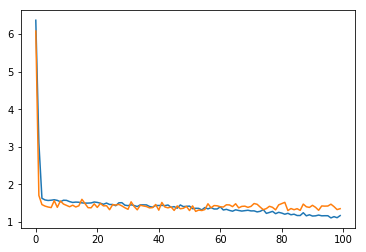

In [45]:
# First 100 epochs
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [46]:
from sklearn.metrics import r2_score

In [47]:
model.load_weights(filepath)

In [48]:
#train_r2 = r2_score(y_true=train_y, y_pred=model.predict(train_x))
train_r2 = r2_score(y_true=train_y[:2000], y_pred=model.predict(train_x[:2000]))
print("Train r2: ", train_r2)

Train r2:  0.29668028745483943


In [49]:
#train_r2 = r2_score(y_true=train_y, y_pred=model.predict(train_x))
test_r2 = r2_score(y_true=test_y, y_pred=model.predict(test_x))
print("Test r2: ", test_r2)

Test r2:  0.20820909127682752
